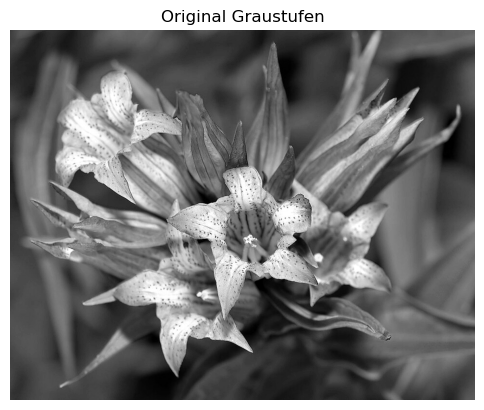

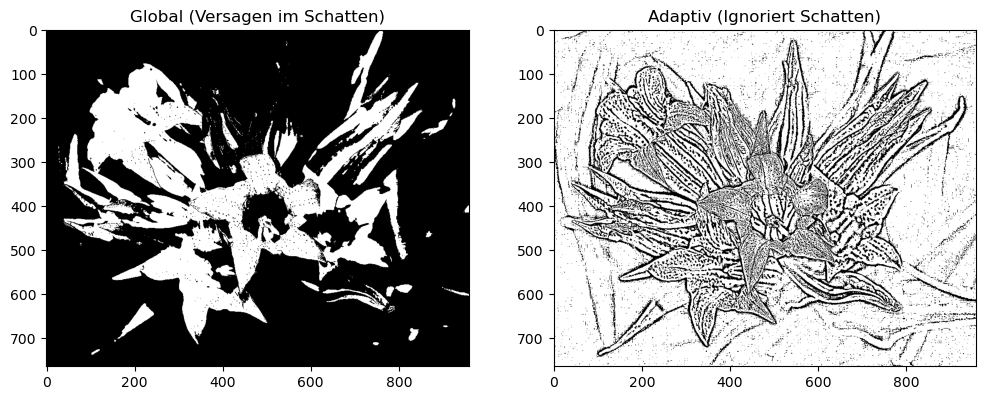

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_shadow = cv2.imread('Gentiana_asclepiadea_gray2.jpg', cv.IMREAD_GRAYSCALE)

plt.figure(figsize=(6, 6))
plt.imshow(image_array, cmap='gray')
plt.title("Original Graustufen")
plt.axis("off")
plt.show()

# Thresholding (Global vs. Adaptiv)

# 1. Globales Thresholding (Standard)
# Wir versuchen einen Wert zu raten, z.B. 127, oder anhand des Histogramms zu bestimmen 
ret, th_global = cv2.threshold(img_shadow, 127, 255, cv2.THRESH_BINARY)

# 2. Adaptive Thresholding (Die Lösung für Schatten)
# Parameter: Bild, MaxVal, Methode (Mean oder Gaussian), Type, BlockSize, C (Konstante, die abgezogen wird)
th_adaptive = cv2.adaptiveThreshold(img_shadow, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY, 11, 2)

# Darstellung
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1); plt.imshow(th_global, cmap='gray'); plt.title("Global (Versagen im Schatten)")
plt.subplot(1, 2, 2); plt.imshow(th_adaptive, cmap='gray'); plt.title("Adaptiv (Ignoriert Schatten)")
plt.show()

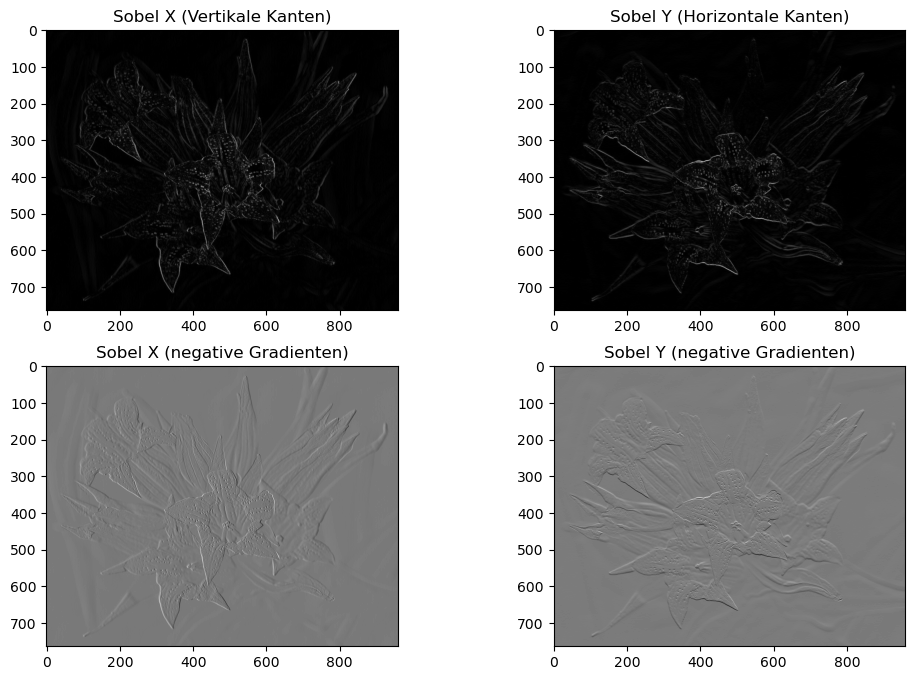

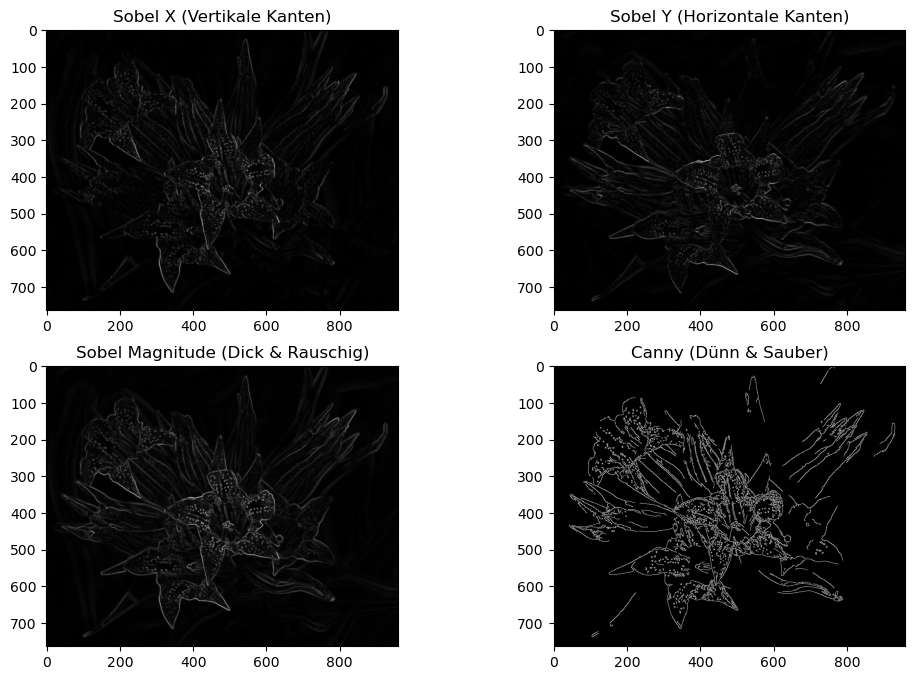

In [33]:
# Kantendetektion (Sobel vs. Canny)
# Hier schauen wir uns an, wie Sobel die Richtungen findet und Canny das saubere Ergebnis liefert.

# Wir nehmen das adaptive Bild oder das Original
img = img_shadow

# 1. Sobel (Gradienten berechnen)
# cv2.CV_64F ist wichtig! Wir brauchen Float-Werte, da Gradienten negativ sein können (von Weiß nach Schwarz).
sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3) # Ableitung nach x (Vertikale Kanten)
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3) # Ableitung nach y (Horizontale Kanten)

# Betrag berechnen (Magnitude)
sobel_combined = cv2.magnitude(sobel_x, sobel_y)


# Darstellung
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1); plt.imshow(np.abs(sobel_x), cmap='gray'); plt.title("Sobel X (Vertikale Kanten)")
plt.subplot(2, 2, 2); plt.imshow(np.abs(sobel_y), cmap='gray'); plt.title("Sobel Y (Horizontale Kanten)")
plt.subplot(2, 2, 3); plt.imshow((sobel_x), cmap='gray'); plt.title("Sobel X (negative Gradienten)")
plt.subplot(2, 2, 4); plt.imshow((sobel_y), cmap='gray'); plt.title("Sobel Y (negative Gradienten)")

plt.show()


# 2. Canny Edge Detector
# Argumente: Bild, MinThreshold, MaxThreshold
canny = cv2.Canny(img, 100, 200)

# Darstellung
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1); plt.imshow(np.abs(sobel_x), cmap='gray'); plt.title("Sobel X (Vertikale Kanten)")
plt.subplot(2, 2, 2); plt.imshow(np.abs(sobel_y), cmap='gray'); plt.title("Sobel Y (Horizontale Kanten)")
plt.subplot(2, 2, 3); plt.imshow(sobel_combined, cmap='gray'); plt.title("Sobel Magnitude (Dick & Rauschig)")
plt.subplot(2, 2, 4); plt.imshow(canny, cmap='gray'); plt.title("Canny (Dünn & Sauber)")

plt.show()

# Warum brauchen wir zwei Schwellenwerte bei Canny? 

# ACHTUNG Spoiler 

# Hysterese. Um zu verhindern, dass eine Kante "zerbröckelt" oder Lücken bekommt, wenn der Gradient leicht schwankt. 
# Wir akzeptieren schwache Kantenstücke nur, wenn sie mit starken verbunden sind.

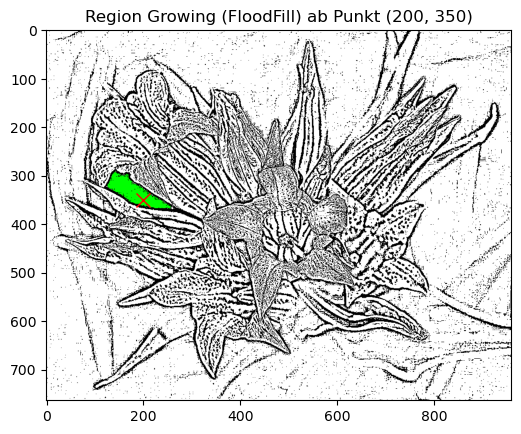

In [36]:
# Region Growing (Flood Fill)
# OpenCV hat keine direkte region_growing Funktion, aber floodFill ist genau das: Ein Region Growing Algorithmus, der bei einem Seed-Punkt startet und ähnliche Nachbarn füllt.

# Szenario: Wir wollen das Innere einer Blüte oder eine Form "ausmalen". 

# Wir nehmen das binäre adaptive Bild
# WICHTIG: .copy() nutzen, da floodFill das Bild direkt verändert!
img_reg = th_adaptive.copy()

# Konvertierung zu BGR, damit wir das Ergebnis farbig markieren können
img_reg_color = cv2.cvtColor(img_reg, cv2.COLOR_GRAY2BGR)

# Maske wird für FloodFill benötigt (muss 2 Pixel größer sein als das Bild)
# Der Algorithmus braucht intern einen 1-Pixel-Rand um das Bild, um "Rand-Checks" zu vermeiden (Boundary Conditions). 
# Das ist ein technisches Implementierungsdetail von OpenCV C++.
h, w = img_reg.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Seed Point wählen (z.B. irgendwo links oben im weißen Bereich)
# In einer echten App würde das per Mausklick passieren
seed_point = (200, 350) 

# Farbe für den Füllbereich (Grün)
new_color = (0, 255, 0)

# FloodFill ausführen
# Parameter: Bild, Maske, Seed, Neue Farbe, Toleranz unten, Toleranz oben
# loDiff und upDiff geben an, wie stark die Helligkeit je Farbkanal abweichen darf
cv2.floodFill(img_reg_color, mask, seed_point, new_color, loDiff=(5,5,5), upDiff=(5,5,5))

plt.figure(figsize=(6, 6))
plt.imshow(img_reg_color)
# Markieren des Startpunkts
plt.plot(seed_point[0], seed_point[1], 'rx', markersize=10)
plt.title(f"Region Growing (FloodFill) ab Punkt {seed_point}")
plt.show()

In [32]:
## Region Growing vs. Thresholding: 
# Erklären Sie, dass Thresholding keine räumliche Information nutzt (Pixel 100 und Pixel 10000 werden gleich behandelt). 
# Region Growing hingegen nutzt die räumliche Nachbarschaft.

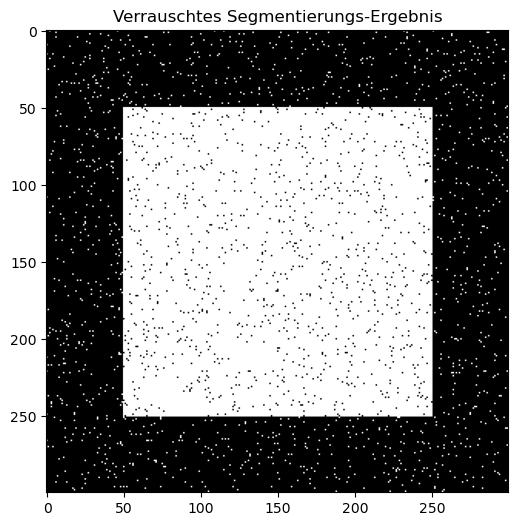

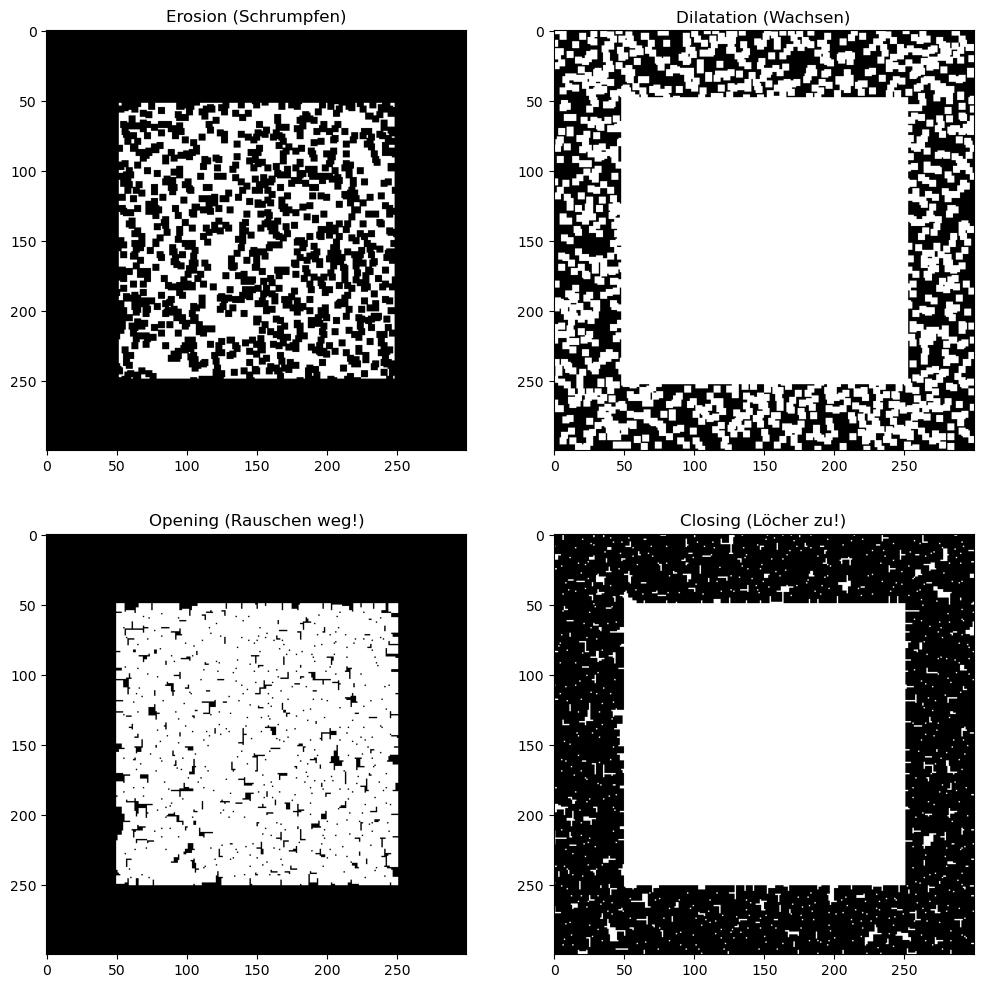

In [34]:
# Morphologische Operationen (Aufräumen)

# Szenario: Unsere Segmentierung (z.B. Canny oder Threshold) ist "schmutzig".
# Wir wollen Rauschen entfernen und Lücken schließen.

# Wir erzeugen ein verrauschtes Binärbild zum Testen
# Ein weißes Rechteck auf schwarzem Grund mit "Salz und Pfeffer" Rauschen
noisy_img = np.zeros((300, 300), dtype="uint8")
cv2.rectangle(noisy_img, (50, 50), (250, 250), 255, -1) # Das Objekt

# Rauschen hinzufügen (Weiße Punkte im Hintergrund, Schwarze Punkte im Objekt)
noise = np.random.randint(0, 2, (300, 300)) * 255
mask_noise = np.random.rand(300, 300) > 0.95 # 5% Rauschen
noisy_img[mask_noise] = noise[mask_noise]

plt.figure(figsize=(6,6))
plt.imshow(noisy_img, cmap='gray')
plt.title("Verrauschtes Segmentierungs-Ergebnis")
plt.show()

# Definition des Kernels (Strukturelement)
# Ein 5x5 Quadrat aus Einsen
kernel = np.ones((5,5), np.uint8)

# 1. Erosion (Rauschen entfernen, aber Objekt schrumpft)
erosion = cv2.erode(noisy_img, kernel, iterations=1)

# 2. Dilatation (Löcher stopfen, aber Rauschen wächst)
dilation = cv2.dilate(noisy_img, kernel, iterations=1)

# 3. Opening (Erosion -> Dilatation)
# Der Goldstandard um weiße Punkte im Hintergrund zu entfernen!
opening = cv2.morphologyEx(noisy_img, cv2.MORPH_OPEN, kernel)

# 4. Closing (Dilatation -> Erosion)
# Der Goldstandard um schwarze Löcher im Objekt zu schließen!
closing = cv2.morphologyEx(noisy_img, cv2.MORPH_CLOSE, kernel)

# Darstellung
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1); plt.imshow(erosion, cmap='gray'); plt.title("Erosion (Schrumpfen)")
plt.subplot(2, 2, 2); plt.imshow(dilation, cmap='gray'); plt.title("Dilatation (Wachsen)")
plt.subplot(2, 2, 3); plt.imshow(opening, cmap='gray'); plt.title("Opening (Rauschen weg!)")
plt.subplot(2, 2, 4); plt.imshow(closing, cmap='gray'); plt.title("Closing (Löcher zu!)")
plt.show()

# LERNZIEL:
# Opening eignet sich perfekt, um kleine Störungen im Hintergrund zu löschen.
# Closing eignet sich perfekt, um ein Objekt "kompakt" zu machen.